<a href="https://colab.research.google.com/github/SageSquash/Major-Project/blob/main/Copy_of_GAAHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#install pygad for genetic algorithm, opencv for image handling and numpy for operations.

!pip install pygad
#!pip install opencv-python
#!pip install numpy
#!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 KB 2.5 MB/s eta 0:00:00


In [4]:
import pygad


In [9]:
import cv2
import numpy as np
import skimage
from skimage import data
from skimage.feature import greycomatrix, greycoprops

def calcHist(im):
    return cv2.calcHist([im], [0], None, [256], [0, 256])
    
def calcPdf(hist):
    return hist / np.sum(hist)

def calcCdf(pdf):
    return np.cumsum(pdf)
    
def gaahe(im, L):
    #essential computations
    hist = calcHist(im)
    pdf = calcPdf(hist)
    cdf = calcCdf(pdf)
    levels = np.arange(L)
    levels = np.reshape(levels, (-1, 1))
    #clipping threshold
    c_median = np.median(im)
    c_mean = np.mean(im)
    c_avg = int((c_median + c_mean) / 2)
    clipped_im = np.clip(im, 0, c_avg)
    clipped_hist = calcHist(clipped_im)
    
    #exposure threshold
    exposure = (np.sum(clipped_hist * levels) / np.sum(clipped_hist)) / L
    e_t = int(L * (1 - exposure))
    print(e_t)
    #compute I_l and I_t
    #I_l = clipped_hist[:exposure_t]
    #I_t = clipped_hist[exposure_t:]
    # Compute the GLCM with a distance of 1 pixel and an angle of 0 degrees
    glcm = greycomatrix(im, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Compute the GLCM features
    I_entropy = skimage.measure.shannon_entropy(img)
    I_energy = greycoprops(glcm, 'energy')
    I_contrast = greycoprops(glcm, 'contrast')
    
    #Compute sobel
    # Apply the Sobel filter
    sobelx = cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize=5)
    # Combine the horizontal and vertical edges
    sobel = cv2.addWeighted(sobelx, 0.5, sobely, 0.5, 0)
    edges = np.sqrt(sobelx**2 + sobely**2)
    sobel_edges = cv2.convertScaleAbs(sobel, alpha=(255.0/np.max(sobel)))
    threshold_value, threshold_image = cv2.threshold(sobel_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(threshold_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    num_edges = np.count_nonzero(threshold_image)
    height, width = im.shape
    
    #assign cost functions
    cf_1 = np.log((I_contrast * np.exp(I_entropy)) / I_energy)
    cf_2 = np.log(np.log(np.sum(edges))) * num_edges/(height*width)
    #cf_3 = cv2.PSNR(img, img_distorted)
    
    
    e_tl = 40
    e_tu = 210

    # for dividing by zero
    P_l1 = np.where(np.sum(clipped_hist[0:e_tl+1]) == 0, np.zeros_like(clipped_hist[0:e_tl+1]), clipped_hist[0:e_tl+1] / np.sum(clipped_hist[0:e_tl+1]))
    P_l2 = np.where(np.sum(clipped_hist[e_tl+1:e_t+1]) == 0, np.zeros_like(clipped_hist[e_tl+1:e_t+1]), clipped_hist[e_tl+1:e_t+1] / np.sum(clipped_hist[e_tl+1:e_t+1]))
    P_u1 = np.where(np.sum(clipped_hist[e_t+1:e_tu+1]) == 0, np.zeros_like(clipped_hist[e_t+1:e_tu+1]), clipped_hist[e_t+1:e_tu+1] / np.sum(clipped_hist[e_t+1:e_tu+1]))
    P_u2 = np.where(np.sum(clipped_hist[e_tu+1:L]) == 0, np.zeros_like(clipped_hist[e_tu+1:L]), clipped_hist[e_tu+1:L] / np.sum(clipped_hist[e_tu+1:L]))
    
    # modified pdfs
    P_l1d = np.array(list(np.sum(P_l1[i] + P_l1) for i in range(P_l1.shape[0])))
    P_l1d = np.reshape(P_l1d, (-1, 1))
    P_l1m = np.where(np.sum(P_l1) == 0, np.zeros_like(P_l1), P_l1 / P_l1d)
    
    P_l2d = np.array(list(np.sum(P_l2[i] + P_l2) for i in range(P_l2.shape[0])))
    P_l2d = np.reshape(P_l2d, (-1, 1))
    P_l2m = np.where(np.sum(P_l2) == 0, np.zeros_like(P_l2), P_l2 / P_l2d)
    
    P_u1d = np.array(list(np.sum(P_u1[i] + P_u1) for i in range(P_u1.shape[0])))
    P_u1d = np.reshape(P_u1d, (-1, 1))
    P_u1m = np.where(np.sum(P_u1) == 0, np.zeros_like(P_u1), P_u1 / P_u1d)

    P_u2d = np.array(list(np.sum(P_u2[i] + P_u2) for i in range(P_u2.shape[0])))
    P_u2d = np.reshape(P_u2d, (-1, 1))
    P_u2m = np.where(np.sum(P_u2) == 0, np.zeros_like(P_u2), P_u2 / P_u2d)

    # cdfs
    C_l1 = calcCdf(P_l1m)
    C_l2 = calcCdf(P_l2m)
    C_u1 = calcCdf(P_u1m)
    C_u2 = calcCdf(P_u2m)
    
    # tfs
    T_l1 = (e_tl * C_l1).astype(np.int32)
    T_l2 = ((e_tl + 1) + (e_t - (e_tl + 1)) * C_l2).astype(np.int32)
    T_u1 = ((e_t + 1) + (e_tu - (e_t + 1)) * C_u1).astype(np.int32)
    T_u2 = ((e_tu + 1) + (L - (e_tu + 1)) * C_u2).astype(np.int32)
    
    #final image and mapping
    out_im = np.zeros_like(im)

    for i in range(e_tl+1):
        mask = np.where(im == i)
        out_im[mask] = T_l1[i]
    for i in range(e_tl+1, e_t+1):
        mask = np.where(im == i)
        out_im[mask] = T_l2[i-e_tl-1]
    for i in range(e_t+1, e_tu+1):
        mask = np.where(im == i)
        out_im[mask] = T_u1[i-e_t-1]
    for i in range(e_tu+1, L):
        mask = np.where(im == i)
        out_im[mask] = T_u2[i-e_tu-1]

    plt.imshow(out_im, cmap='gray', interpolation='nearest')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    cv2.imwrite('image_output.png', out_im)
    
    plt.imshow(im, cmap='gray', interpolation='nearest')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()
    
    #code below this line is not tried, if the block above executes i will paste it in function for optimization
    def fitness_func(solution, solution_idx):
        # The fitness function calulates the sum of products between each input and its corresponding weight.

    
        # The value 0.000001 is used to avoid the Inf value when the denominator numpy.abs(output - desired_output) is 0.0.
        fitness = 0.33 * cf_1 + 0.33 * cf_2 + 0.33 * cf_3
        return fitness
    ga_instance = pygad.GA(num_generations=50,
                       fitness_func=fitness_func,
                       sol_per_pop=50,
                       num_genes=2,
                       num_parents_mating = 10,
                       mutation_type="adaptive",
                       mutation_by_replacement=True,
                       crossover_probability=0.8,
                       gene_space = [range(0, e_t), range(e_t+1, L-1)],
                       gene_type=int,
                       mutation_percent_genes=(0.01, 0.01))

151


/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.9/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
<ipython-input-9-0d510802695d>:70: RuntimeWarning: invalid value encountered in true_divide
  P_u1 = np.where(np.sum(clipped_hist[e_t+1:e_tu+1]) == 0, np.zeros_like(clipped_hist[e_t+1:e_tu+1]), clipped_hist[e_t+1:e_tu+1] / np.sum(clipped_hist[e_t+1:e_tu+1]))
<ipython-input-9-0d510802695

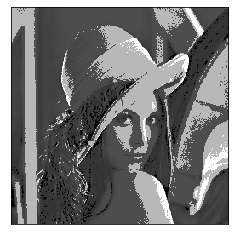

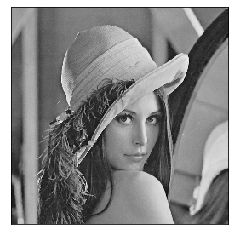

/usr/local/lib/python3.9/dist-packages/pygad/pygad.py:545: UserWarning: The percentage of genes to mutate (0.01) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate ({mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes[idx], mutation_num=mutation_num_genes[idx]))
/usr/local/lib/python3.9/dist-packages/pygad/pygad.py:600: UserWarning: The mutation_by_replacement parameter is set to True while the mutation_type parameter is not set to random but (adaptive). Note that the mutation_by_replacement parameter has an effect only when mutation_type='random'.
  if not self.suppress_warnings: warnings.warn(

In [10]:
from matplotlib import pyplot as plt
# Load the input image
img = cv2.imread('/content/lena.png', cv2.IMREAD_GRAYSCALE)
gaahe(img, 256)

In [7]:
import math
import numpy as np
from math import log2
from skimage.metrics import structural_similarity as ssim

class Quantitation:
  # Absolute Mean Brightness Error
  def AMBE(self, image_input, image_output):
    return abs(np.mean(image_input) - np.mean(image_output))

  # Mean Square Error
  def MSE(self, image_input, image_output):
    # err = np.sum((image_input.astype("float") - image_output.astype("float")) ** 2)
    # err /= float(image_input.shape[0] * image_input.shape[1])
    # return err
    err = 10 * math.log10((255 * 255)/cv2.PSNR(image_input, image_output))
    return err

  # Peak Signal to Noise Ratio
  def PSNR(self, image_input, image_output):
    # return 10 * math.log10((255 * 255) / MSE(image_input, image_output))
    return cv2.PSNR(image_input, image_output)
  
  def SNR(self, image_input, image_output):
    ibg = 0
    signal = ((image_input + image_output) / 2 - ibg).sum()
    f = (0.5 ** 0.5) * ((2 / np.pi) ** -0.5)
    noise = np.abs(image_input - image_output).sum() * f
    snr = signal / noise
    return snr

  def SSIM(self, image_input, image_output):
    # return ssim(image_input, image_output, win_size=1, use_sample_covariance=False)
    return ssim(image_input, image_output,multichannel=True)
     

In [14]:
q = Quantitation()
img_output = cv2.imread('/content/image_output.png', cv2.IMREAD_GRAYSCALE)
print(q.MSE(img,img_output))
print(q.PSNR(img,img_output))
print(q.AMBE(img,img_output))
print(q.SNR(img,img_output))
print(q.SSIM(img,img_output))
# print(calculate_entropy(img_output))

36.44517407448069
14.742222222620109
38.58921813964844
1.9269354375668646
0.6405524717872567


<ipython-input-7-e14ebd675d1e>:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(image_input, image_output,multichannel=True)
